## Inital Setup and Data Import

In [569]:
import numpy as np
import pandas as pd
import re as re
import pickle

from sklearn.preprocessing import Imputer

import matplotlib.pyplot as plt
import seaborn as sns
import time
import scipy.stats as st
import scipy.special as spec
import math

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit,StratifiedKFold, RandomizedSearchCV, GridSearchCV

from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, precision_score, recall_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

from math import log

from boostaroota import BoostARoota
from xgboost import XGBClassifier, plot_importance

##########

import warnings
warnings.filterwarnings("ignore")

import nbimporter
#from libraries_setup import AllLibraries
from setup_code import *

#AllLibraries()

###### Installing packages ##########
# import sys
# !{sys.executable} -m pip install boostaroota

In [570]:
data = pd.read_csv('train.csv')
data.set_index('PassengerId', inplace=True)


scoring = pd.read_csv('test.csv')
scoring.set_index('PassengerId', inplace=True)

In [571]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [572]:
y = data.loc[:,'Survived']
X = data.drop ('Survived', 1)

In [573]:
random = 1992
test_prc = 0.2

X_train , X_test, y_train, y_test = train_test_split(X, y, test_size = test_prc, random_state = random)
X_train , X_calib, y_train, y_calib = train_test_split(X_train, y_train, test_size = 0.1, random_state = random + 50)

In [574]:
data_train = X_train
data_train['Survived'] = y_train

data_test = X_test
data_test['Survived'] = y_test

data_calib = X_calib
data_calib['Survived'] = y_calib

datasets_all = [data_calib, data_train, data_test, scoring]
#datasets_all = [ data_train, data_test, scoring]

In [575]:
data_test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
PassengerId,,,,,,,,,,,
144,3,"Burke, Mr. Jeremiah",male,19.0,0,0,365222,6.7500,NaN,Q,0
117,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q,0
105,3,"Gustafsson, Mr. Anders Vilhelm",male,37.0,2,0,3101276,7.9250,NaN,S,0
65,1,"Stewart, Mr. Albert A",male,NaN,0,0,PC 17605,27.7208,NaN,C,0
447,2,"Mellinger, Miss. Madeleine Violet",female,13.0,0,1,250644,19.5000,NaN,S,1


In [576]:
##maybe i should split feature engineering into "might create overfitting" vs not

In [577]:
#ShowTypes(data_train)
ShowLevels(data_train)

Number of records in the dataset is  640
 
Number of  Name  levels:  640
Number of  Sex  levels:  2
Number of  Ticket  levels:  522
Number of  Cabin  levels:  118
Number of  Embarked  levels:  3


In [578]:
############### FEATURE ENGINEERING ####################

##### Creating variables

for data in datasets_all:
    create_new_var (data)

In [579]:
#### Impact Coding

variables_to_code = ['Cabin', 'Ticket', 'Last_name', 'Other_last_name', 'Ticket_first', 'Ticket_second']

for variable in variables_to_code:
    
    impact_variable_name = variable + '_impact'
    
    #create impact coding  on calibration
    data_calib = impact_coding(data_calib, variable)
    
    #apply impact coding to all other data sets, and fill NAs with 0 when there is no match
    coded_impacts = data_calib[[variable, impact_variable_name]].drop_duplicates()
    
    data_train = data_train.reset_index().merge(coded_impacts, on=variable, how = 'left').set_index('PassengerId')
    data_train[impact_variable_name] = data_train[impact_variable_name].fillna(0)
    
    data_test = data_test.reset_index().merge(coded_impacts, on=variable, how = 'left').set_index('PassengerId')
    data_test[impact_variable_name] = data_test[impact_variable_name].fillna(0)
    
    scoring = scoring.reset_index().merge(coded_impacts, on=variable, how = 'left').set_index('PassengerId')
    scoring[impact_variable_name] = scoring[impact_variable_name].fillna(0)

In [580]:
ShowTypes(data_calib)

 Categorical variables of the dataset are: 

Name
Sex
Ticket
Cabin
Embarked
Title
Last_name
Other_full_name
Other_last_name
Cabin_letter
Ticket_first
Ticket_second
 
 Numerical variables of the dataset are: 

Pclass
Age
SibSp
Parch
Fare
Survived
FamilySize
IsAlone
Cabin_impact
Ticket_impact
Last_name_impact
Other_last_name_impact
Ticket_first_impact
Ticket_second_impact


In [581]:
##### Correct variables' formats
datasets_all = [data_calib, data_train, data_test, scoring]

variables_to_categories = ['Pclass', 'IsAlone', 'SibSp', 'Parch', 'FamilySize']
to_type = 'object'

for data in datasets_all:
    for variable in variables_to_categories:
        data.loc[:,variable] = data[variable].astype(to_type)
        
for data in datasets_all:
    for variable in ['SibSp', 'Parch','FamilySize']:
        data.loc[data[variable].isin ([0,1,2,3,4]) == False , variable]  = '5+'

In [582]:
##### Imputations (for regression imputer your columns have to have the proper format)

data_calib = impute_most_frequent (data_calib, 'Embarked')
data_train = impute_most_frequent (data_train, 'Embarked')
data_test = impute_most_frequent (data_test, 'Embarked')
scoring = impute_most_frequent (scoring, 'Embarked')

data_calib = impute_regressor(data_calib, 'Age', 1)
data_train = impute_regressor(data_train, 'Age', 1)
data_test = impute_regressor(data_test, 'Age', 1)
scoring = impute_regressor(scoring, 'Age', 1)

scoring = impute_regressor(scoring, 'Fare', 0)

In [583]:
list(data_train)

['Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked',
 'Survived',
 'FamilySize',
 'IsAlone',
 'Title',
 'Last_name',
 'Other_full_name',
 'Other_last_name',
 'Cabin_letter',
 'Ticket_first',
 'Ticket_second',
 'Cabin_impact',
 'Ticket_impact',
 'Last_name_impact',
 'Other_last_name_impact',
 'Ticket_first_impact',
 'Ticket_second_impact',
 'Age_mis_ind']

In [584]:
variables_to_delete = ['Name', 'Ticket', 'Cabin', 'Last_name','Other_full_name', 'Other_last_name', 
                       'Ticket_first', 'Ticket_second']

for variable in variables_to_delete:
    
    data_calib = data_calib.drop (variable, 1) # 1 for columns, 0 for rows
    data_train = data_train.drop (variable, 1) 
    data_test = data_test.drop (variable, 1) 
    scoring = scoring.drop (variable, 1) 

In [585]:
X_train.to_csv('check.csv', index = True, header = True)
X_train.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,FamilySize,IsAlone,Title,Last_name,Other_full_name,Other_last_name,Cabin_letter,Ticket_first,Ticket_second
PassengerId,,,,,,,,,,,,,,,,,,,,
888,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,1,1,1,Miss,Graham,None,None,B,NaN,112053
493,1,"Molson, Mr. Harry Markland",male,55.0,0,0,113787,30.5000,C30,S,0,1,1,Mr,Molson,None,None,C,NaN,113787
637,3,"Leinonen, Mr. Antti Gustaf",male,32.0,0,0,STON/O 2. 3101292,7.9250,NaN,S,0,1,1,Mr,Leinonen,None,None,NaN,STON/O,2.
262,3,"Asplund, Master. Edvin Rojj Felix",male,3.0,4,2,347077,31.3875,NaN,S,1,7,0,Master,Asplund,None,None,NaN,NaN,347077
860,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C,0,1,1,Mr,Razi,None,None,NaN,NaN,2629


In [586]:
ShowTypes(data_train)

 Categorical variables of the dataset are: 

Pclass
Sex
SibSp
Parch
Embarked
FamilySize
IsAlone
Title
Cabin_letter
Age_mis_ind
 
 Numerical variables of the dataset are: 

Age
Fare
Survived
Cabin_impact
Ticket_impact
Last_name_impact
Other_last_name_impact
Ticket_first_impact
Ticket_second_impact


In [587]:
data_calib = create_dummies(data_calib,0)
data_train = create_dummies(data_train,0)
data_test = create_dummies(data_test,0)
scoring = create_dummies(scoring,0)

In [588]:
# interaction variables

for data in [data_calib, data_train, data_test, scoring]:
    data['Age_Pclass_1']= data['Age'] * data['Pclass_1']
    data['Age_Pclass_2']= data['Age'] * data['Pclass_2']
    data['Age_Pclass_3']= data['Age'] * data['Pclass_3']
    #data.loc[:,'Age_Class'] = data['Age_Class'].astype('float32')

In [603]:
#### Feature Selection

# BoostARoota from: https://github.com/chasedehan/BoostARoota# BoostAR 
br = BoostARoota(metric='logloss', silent=True)

y_train = data_train.loc[:,'Survived']
X_train = data_train.drop ('Survived', 1)

br.fit(X_train,y_train)
X_train_reduced = br.transform(X_train)

print("The algorithm reduced the data from " + str(X_train.shape[1]) + " to " + 
      str(X_train_reduced.shape[1]) + " variables")

The algorithm reduced the data from 54 to 33 variables


In [604]:
important_variables = list (X_train_reduced)
#important_variables = list (X_train)

In [605]:
#ShowTypes(data_train)
#data_train.isna().sum()
#ShowLevels(data_calib)

## Modeling

In [606]:
y_train = data_train.loc[:,'Survived']
X_train = data_train.loc[:, important_variables]

y_test = data_test.loc[:,'Survived']
X_test = data_test.loc[:, important_variables]

X_scoring = scoring.loc[:, important_variables]

In [607]:
print ("Check: \n" + 
       "Training size is " + str(X_train.shape) + "\n" + 
       "Testing size is " + str(X_test.shape) + "\n" + 
       "Scoring size is " + str(X_scoring.shape) 
      )

Check: 
Training size is (640, 33)
Testing size is (179, 33)
Scoring size is (418, 33)


In [608]:
X_test.head()

,Age,Fare,Ticket_impact,Other_last_name_impact,Ticket_first_impact,Pclass_1,Pclass_2,Pclass_3,Sex_female,SibSp_0,...,Title_Rare,Title_Rev,Cabin_letter_C,Cabin_letter_D,Cabin_letter_E,Cabin_letter_G,Age_mis_ind_0.0,Age_Pclass_1,Age_Pclass_2,Age_Pclass_3
PassengerId,,,,,,,,,,,,,,,,,,,,,
144,19.0,6.7500,0.0,0.0,0.000000,0,0,1,0,1,...,0,0,0,0,0,0,1,0.0,0.0,19.0
117,70.5,7.7500,0.0,0.0,0.000000,0,0,1,0,1,...,0,0,0,0,0,0,1,0.0,0.0,70.5
105,37.0,7.9250,0.0,0.0,0.000000,0,0,1,0,0,...,0,0,0,0,0,0,1,0.0,0.0,37.0
65,31.1,27.7208,0.0,0.0,1.139404,1,0,0,0,1,...,0,0,0,0,0,0,0,31.1,0.0,0.0
447,13.0,19.5000,0.0,0.0,0.000000,0,1,0,1,1,...,0,0,0,0,0,0,1,0.0,13.0,0.0


### Parameter Tuning

In [609]:
############################ TUNNING RANDOM FOREST ########################################

# rf = RandomForestClassifier()
# #rf.get_params()

# row_num = X_train.shape[0]

# n_estimators_start = 200
# n_estimators_end =  2000

# max_depth_start = 10
# max_depth_end = 110

# min_samples_split_start =  round(0.01*row_num) #2
# min_samples_split_end = round(0.03*row_num) #10

# min_samples_leaf_start = 1
# min_samples_leaf_end = 20 #4


# max_features = ['auto', 'sqrt']
# bootstrap = [True, False]

# # Create the random grid
# random_grid = {'n_estimators': st.randint (n_estimators_start, n_estimators_end),
#                'max_depth': st.randint (max_depth_start, max_depth_end),
#                'min_samples_split': st.randint (min_samples_split_start, min_samples_split_end),
#                'min_samples_leaf': st.randint (min_samples_leaf_start, min_samples_leaf_end),
#                'max_features': max_features,
#                'bootstrap': bootstrap}


# rf_random = RandomizedSearchCV(estimator = rf, 
#                                            param_distributions = random_grid, 
#                                            n_iter = 100, cv = 5, scoring = 'roc_auc', verbose=False, 
#                                            random_state=42, n_jobs = -1)

# start = time.time()
# rf_random.fit(X_train,y_train)
# end = time.time()

# print("Execution Time Was: ", end - start, "seconds")

# RandomForestClassifierTuned = RandomForestClassifier()
# RandomForestClassifierTuned.set_params(**rf_random.best_params_)

##########################################################################################

In [610]:
############################ TUNNING GRADIENT BOOSTING ########################################

#best model (roc = 82.727483): with n_est 3 - 40; max_depth 3-40; learning rate 0.05 - 0.4

#https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
# consider using GridSearchCV

gb = GradientBoostingClassifier()
#rf.get_params()

row_num = X_train.shape[0]

learning_rate_start = 0.09 #0.03
learning_rate_end = 0.2 #0.3

n_estimators_start = 3
n_estimators_end =  40 #80

max_depth_start = 3
max_depth_end = 40 #20

min_samples_split_start = round(0.01*row_num)
min_samples_split_end = round(0.03*row_num)

min_samples_leaf_start = 1
min_samples_leaf_end = 20 


random_grid = {  
                "learning_rate": st.uniform (learning_rate_start, learning_rate_end),
                "n_estimators": st.randint (n_estimators_start, n_estimators_end),
                "max_depth": st.randint (max_depth_start, max_depth_end)
            }


# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
gb_random = RandomizedSearchCV(estimator = gb, 
                                           param_distributions = random_grid, 
                                           n_iter = 100, cv = 10, scoring = 'roc_auc', verbose=False, 
                                           random_state=42, n_jobs = -1)


start = time.time()
gb_random.fit(X_train,y_train)
end = time.time()

print("Execution Time Was: ", end - start, "seconds")

GradientBoostingClassifierTuned = GradientBoostingClassifier()
GradientBoostingClassifierTuned.set_params(**gb_random.best_params_)
GradientBoostingClassifierTuned.get_params()
############################################################################################

Execution Time Was:  23.99012303352356 seconds


{'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.14083272981394776,
 'loss': 'deviance',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 28,
 'presort': 'auto',
 'random_state': None,
 'subsample': 1.0,
 'verbose': 0,
 'warm_start': False}

In [611]:
############################ TUNNING XGBOOST ########################################

#https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
# consider using GridSearchCV

xgb = XGBClassifier()
#rf.get_params()

row_num = X_train.shape[0]

learning_rate_start = 0.05
learning_rate_end = 0.4

n_estimators_start = 3
n_estimators_end =  80

max_depth_start = 3
max_depth_end = 50

one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

random_grid = {  
    "n_estimators": st.randint(n_estimators_start, n_estimators_end),
    "max_depth": st.randint(max_depth_start, max_depth_end),
    "learning_rate": st.uniform(learning_rate_start, learning_rate_end),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive
}

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
xgb_random = RandomizedSearchCV(estimator = xgb, 
                                           param_distributions = random_grid, 
                                           n_iter = 100, cv = 10, scoring = 'roc_auc', verbose=False, 
                                           random_state=42, n_jobs = -1)


start = time.time()
xgb_random.fit(X_train,y_train)
end = time.time()

print("Execution Time Was: ", end - start, "seconds")

XGBClassifierTuned = XGBClassifier()
XGBClassifierTuned.set_params(**xgb_random.best_params_)
XGBClassifierTuned.get_params()
#####################################################################################

Execution Time Was:  5.582403898239136 seconds


{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 0.9697415755070925,
 'gamma': 6.0789439379425865,
 'learning_rate': 0.20172227935421955,
 'max_delta_step': 0,
 'max_depth': 11,
 'min_child_weight': 11.507137456078535,
 'missing': None,
 'n_estimators': 59,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0.23213920331714424,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': True,
 'subsample': 0.9622365109010307}

### Comparing Different Classifiers

In [612]:
classifiers = [
    KNeighborsClassifier(3),
  # SVC(kernel="rbf", C=0.025, probability=True),
    NuSVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
  #  GaussianNB(),
  #  LinearDiscriminantAnalysis(),
  #  QuadraticDiscriminantAnalysis(),
    XGBClassifier(),
 #   RandomForestClassifierTuned,
    GradientBoostingClassifierTuned,
    XGBClassifierTuned
]

names = [
        'KNeighborsClassifier',
   #     'Support Vector Machine',
        'NuSVC',
        'Decision Tree',
        'Random Forest',
        'AdaBoost',
        'Gradient Boosting',
   #     'Gaussian NB',
   #     'Linear Discriminant Analysis',
   #     'Quadratic Discriminant Analysis',
        'XGBoost',
   #     'Random Forest Tuned',
        'Gradient Boosting Tuned',
        'XGBoost Tuned'
]

In [613]:
folds = 10
random = 23
test_prc = 0.3

#X_train , X_test, y_train, y_test = train_test_split( X, y, test_size = test_prc, random_state = random)

sss = StratifiedShuffleSplit(n_splits = folds, test_size=test_prc, random_state=random)
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = random)


log_cols=["Index", "Classifier", "ROC", "Accuracy", "Log Loss", 'Precision', 'Recall']
log = pd.DataFrame(columns=log_cols)

index = 0

for train_index, test_index in skf.split(X_train, y_train):
    
    index += 1
    
    X_train_kf, X_test_kf = X_train.values[train_index], X_train.values[test_index]
    y_train_kf, y_test_kf = y_train.iloc[train_index], y_train.iloc[test_index]

    # FOR MORE METRICS SEE: http://scikit-learn.org/stable/modules/model_evaluation.html

    for name, clf in zip(names,classifiers):

        clf.fit(X_train_kf, y_train_kf)

        y_pred_kf = clf.predict(X_test_kf)
        y_pred_prob_kf = clf.predict_proba(X_test_kf)

        #name = clf.__class__.__name__

        roc = 100*roc_auc_score(y_test_kf, y_pred_kf)
        acc = 100*accuracy_score(y_test_kf, y_pred_kf)
        ll = log_loss(y_test_kf, y_pred_prob_kf)

        prec = 100*precision_score(y_test_kf, y_pred_kf)
        recall = 100*recall_score(y_test_kf, y_pred_kf)

        log_entry = pd.DataFrame([[index, name, roc, acc, ll, prec, recall]], columns=log_cols)
        log = log.append(log_entry)

#log
final_log = log.groupby(['Classifier'])["ROC", "Accuracy", "Log Loss", 'Precision', 'Recall'].mean()
final_log.sort_values(by = 'ROC', ascending = False, inplace = True)

In [614]:
final_log

,ROC,Accuracy,Log Loss,Precision,Recall
Classifier,,,,,
Gradient Boosting Tuned,83.236538,84.702266,0.400310,82.747029,76.883333
Gradient Boosting,82.017949,83.925824,0.413208,83.358055,73.683333
XGBoost,81.778205,83.449557,0.404411,81.535507,74.466667
AdaBoost,80.646795,81.711042,0.667452,76.719579,76.050000
Random Forest,80.365385,82.348443,1.573426,81.476334,71.666667
XGBoost Tuned,79.759615,82.353327,0.429267,83.022053,68.416667
Decision Tree,78.275000,78.908234,7.240944,72.293015,75.633333
KNeighborsClassifier,69.999359,72.498436,3.771401,65.836831,59.050000
NuSVC,69.907051,73.116300,0.543384,68.771697,55.833333


### Running The Model

In [615]:
# running on the whole dataset
best_classifier = GradientBoostingClassifierTuned #GradientBoostingClassifierTuned
best_classifier.fit(X_train, y_train)

y_pred = best_classifier.predict(X_test)
y_pred_prob = best_classifier.predict_proba(X_test)

#X_test['Survived_pred'] = y_pred
acc = 100*accuracy_score(y_test, y_pred)
acc

77.09497206703911

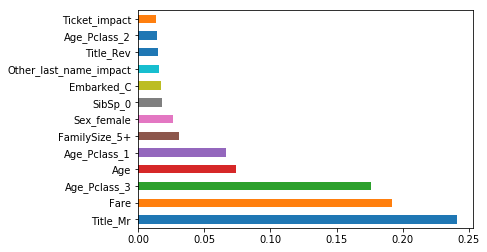

In [616]:
features_plot = pd.Series(best_classifier.feature_importances_, index=X_test.columns).nlargest(13).plot(kind='barh')

## Submitting to Kaggle

In [562]:
# running on the whole dataset
y = pd.concat([y_train, y_test])
X = pd.concat([X_train, X_test])
X_scoring = scoring.loc[:, important_variables]

In [563]:
#X.isna().sum()
# X['Cabin_letter_T'] = X['Cabin_letter_T'].fillna(0)
# X['Cabin_letter_F'] = X['Cabin_letter_F'].fillna(0)

# X_scoring['Cabin_letter_F'] = X_scoring['Cabin_letter_F'].fillna(0)
# X_scoring['Cabin_letter_T'] = 0

In [564]:
print ("Check: \n" + 
       "Scoring size is " + str(X_scoring.shape) + "\n" + 
       "Training size is " + str(X.shape) + "\n"
      )

Check: 
Scoring size is (418, 25)
Training size is (819, 25)



In [565]:
best_classifier.fit(X, y)

y_pred = best_classifier.predict(X_scoring)
#y_pred_prob = best_classifier.predict_proba(X_scoring)

In [566]:
X_scoring['Survived'] = y_pred

submission = X_scoring[['Survived']]
submission.reset_index(inplace=True)
submission.to_csv('submission.csv', index = False, header = True)

In [567]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,1
3,895,0
4,896,1
